**This notebook has several old exploration code and is not using the latest dgsres.powder.fit module. The fit_and_interpolate_resolution-Ei_130 is cleaner.**

The fitting may need to be done several times to find the best range of the parameters. After these adjustments, all parameters have few outliers. And it is possible to use np.interp to interpolate some of the parameter-vs-E curves.

# Tools

In [76]:
%matplotlib notebook
from matplotlib import pyplot as plt

In [77]:
import numpy as np
import histogram.hdf as hh, histogram as H
import lmfit

In [78]:
import sys
sys.path.append('/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/dgsres')

In [79]:
from dgsres import icg

# Residual function

In [80]:
Ei=300.
# geometry info for ARCS
geom = icg.Geom(l1=11.6, l2=2.0, l3=3.)
# this must match the path in mcvine-resolutions-Ei_300.ipynb
datadir = "/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/Ei_300_Q_4.47/resolutionFullCircle/ie"
Q = 4.47

In [81]:
def residual(params, x, data, eps_data):
    a = params['a']
    b = params['b']
    R = params['R']
    sigma = params['sigma']
    t0 = params['t0']
    model = icg.resolution(x, Ei=Ei, E0=E0, a=a, b=b, R=R, sigma=sigma, t0=t0, geom=geom)
    sum = model.sum()
    if np.abs(sum)<1e-10: sum = 1e-10
    model/=sum
    model[model!=model] = np.nanmax(model)
    # plt.plot(data, )
    # plt.plot(model)
    ret = (data-model) / eps_data
    # print np.sum(ret**2)/ret.size
    return ret

# fitting parameters
The ranges here were revised several times to minimize the outliers

In [82]:
params = lmfit.Parameters()
# at first the max was 1.0. after trying it, it seems better to set max to 0.6 because points outside the range look like outliers
params.add('a', min=0., max=.52)
# at first the max was 0.3. 
params.add('b', min=0., max=.11)
params.add('R', value=0.3, vary=False)
params.add('sigma', min=0., max=20.)
params.add('t0', min=0., max=100.)

In [83]:
def getData(E0=120.):
    # get mcvine sim result
    res_E = hh.load("%s/ie-E_%s.h5" % (datadir, E0))
    x = res_E.E
    y0 = res_E.I
    scale = y0.sum()
    y0/=scale
    y0err = res_E.E2**.5
    y0err/=scale
    return x, y0, y0err

def fit(E0=120.):
    # get mcvine sim result
    x, y0, y0err = getData(E0)
    # prepare fitting data
    data = y0
    eps_data = 1.
    # fit
    out = lmfit.minimize(residual, params, args=(x, data, eps_data), method='differential_evolution')
    return out

In [84]:
# ls /SNS/users/lj7/simulations/ARCS/graphite/resolution/Ei_300_demo/out/

# Fitting

In [85]:
%%time
results = {}
for E0 in np.arange(0., 200., 5.):
    print E0
    results[E0] = fit(E0)
    continue

0.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0
85.0
90.0
95.0
100.0
105.0
110.0
115.0
120.0
125.0
130.0
135.0
140.0
145.0
150.0
155.0
160.0
165.0
170.0
175.0
180.0
185.0
190.0
195.0
CPU times: user 1min 20s, sys: 1.57 s, total: 1min 21s
Wall time: 1min 19s


<IPython.core.display.Javascript object>


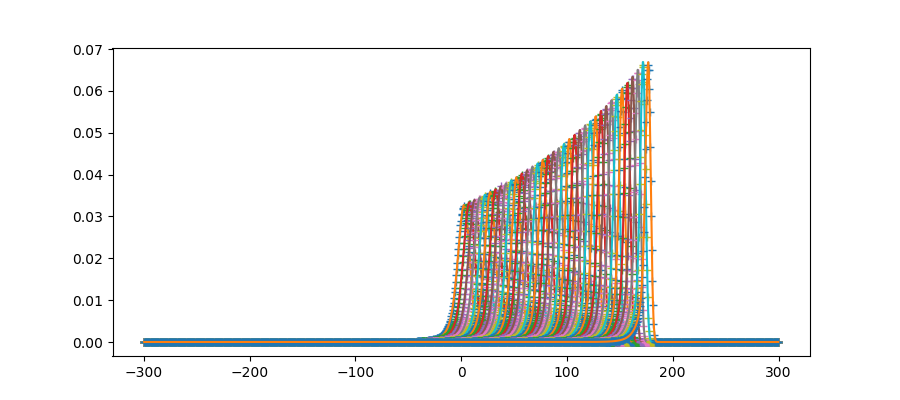

In [86]:
plt.figure(figsize=(9, 4))
for E0 in np.arange(0., 180., 5.):
    x,y0,y0err = getData(E0)
    y = icg.resolution(x, Ei=300., E0=E0, geom=geom, **results[E0].params.valuesdict())
    y/=y.sum()
    # plt.errorbar(x, y0, y0err)
    plt.plot(x,y0, '+')
    plt.plot(x, y)
plt.show()

In [93]:
E0s = np.arange(0., 180., 35.)
def get_p_list(name):
    return [results[E0].params[name].value for E0 in E0s]

old plotting code 
```
plt.figure()
plt.plot(E0s, get_p_list('a'), label='a')
plt.plot(E0s, get_p_list('b'), label='b')
plt.plot(E0s, get_p_list('R'), label='R')
plt.plot(E0s, get_p_list('sigma'), label='sigma')
plt.legend()
plt.show()
```

old plotting code
```
plt.figure()
plt.plot(E0s, get_p_list('t0'), label='t0')
plt.legend()
plt.show()
```

The plot generated by the following cell can clearly show how many outliers exist for parameters. Try to minimize the number of outliers by changing the parameters (up in the `fitting parameters` section) and execute all the cells in between that cell and the next cell

<IPython.core.display.Javascript object>


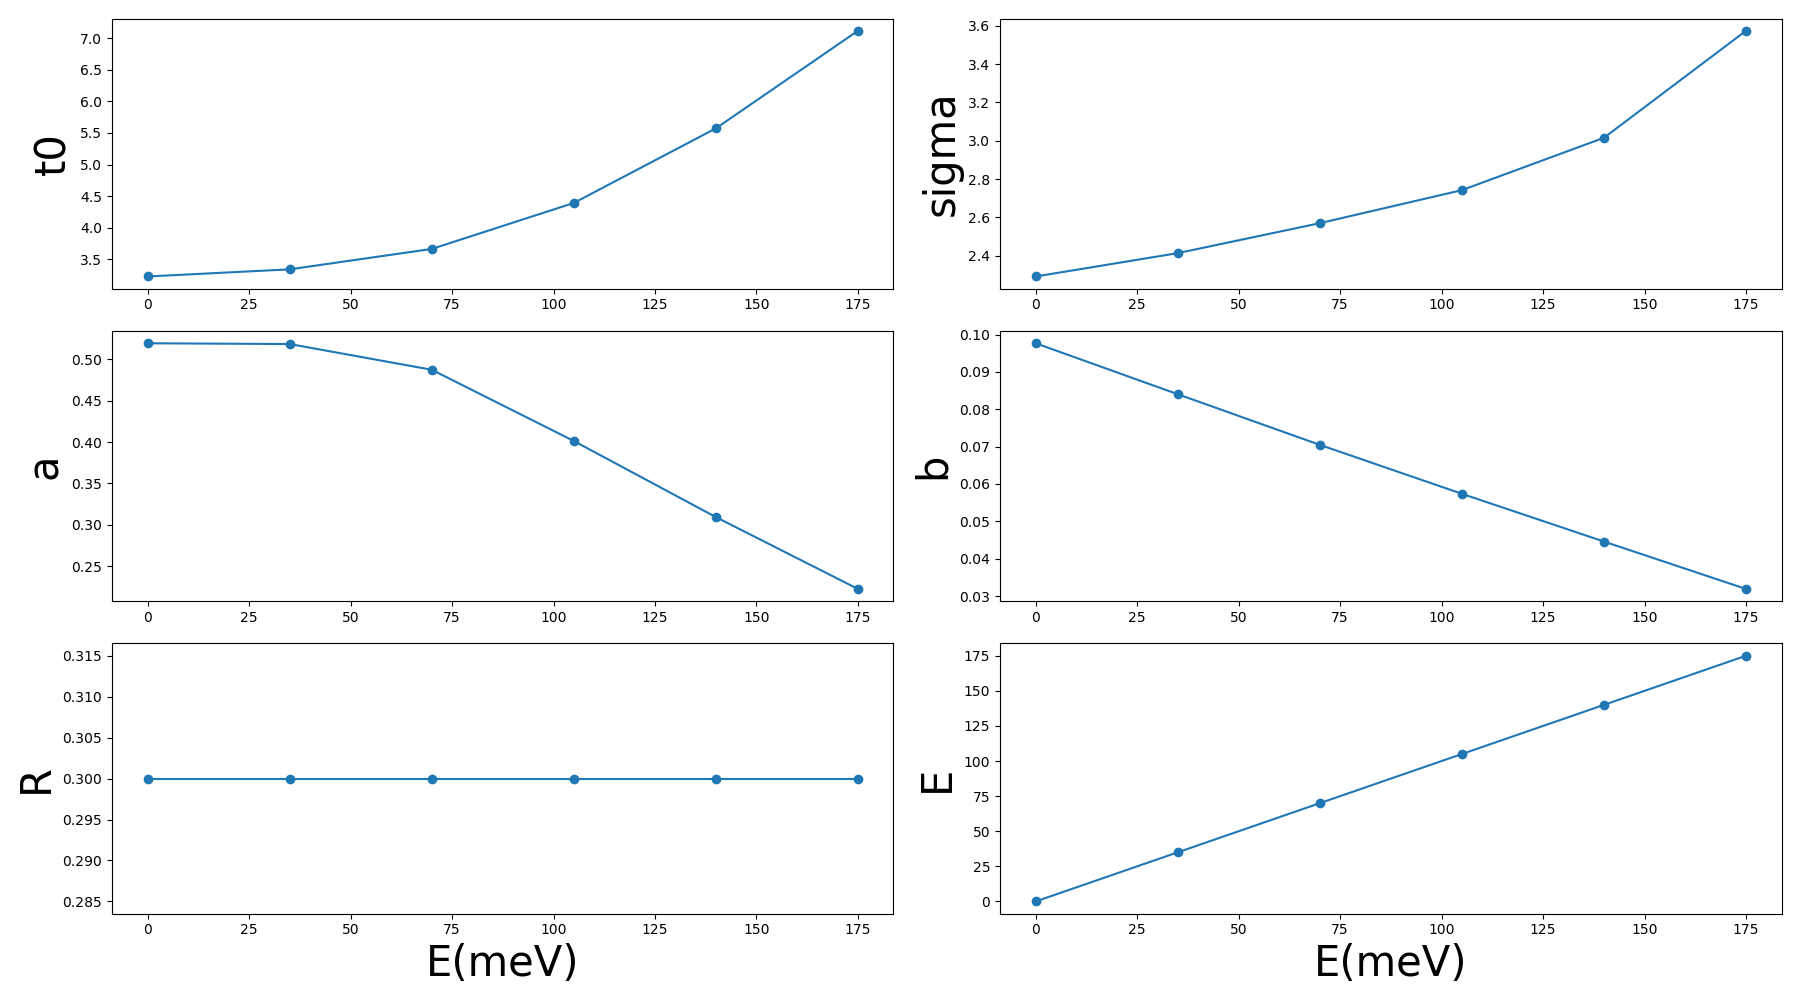

In [99]:
variables = 't0 sigma a b R'.split()
plt.figure(figsize=(18,10))
for i,v in enumerate(variables):
    plt.subplot(3, 2, i+1)
#     plt.plot(E0s, get_p_list(v), '-o', label=v)
    plt.plot(E0s, get_p_list(v), '-o')
    plt.ylabel(v, fontsize=30)
    plt.legend()
    continue
plt.xlabel('E(meV)', fontsize=30)
plt.subplot(3, 2, 6)
plt.plot(E0s, E0s, '-o')
plt.ylabel('E', fontsize=30)
plt.legend()
plt.xlabel('E(meV)', fontsize=30)
plt.tight_layout()
plt.show()

In [100]:
E0 = 0.
print results[E0].params['a'].value
print results[E0].params['b'].value

0.519553660149
0.0976588074822


# Interpolate

In [101]:
# a2, a1, a0 = np.polyfit(E0s, get_p_list('a'), 2)

## a

<IPython.core.display.Javascript object>


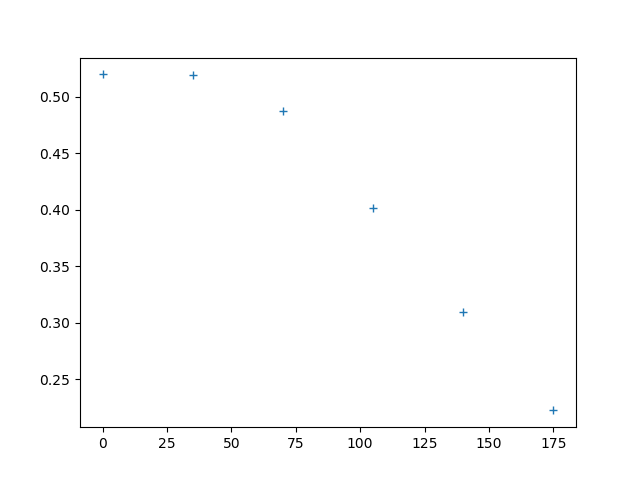

In [102]:
plt.figure()
x = E0s
y = np.array(get_p_list('a'))
plt.plot(x, y, '+')

There is one outlier. Here for simplicity we remove two points

In [103]:
good = y < 0.5
xgood = x[good]; ygood = y[good]

<IPython.core.display.Javascript object>


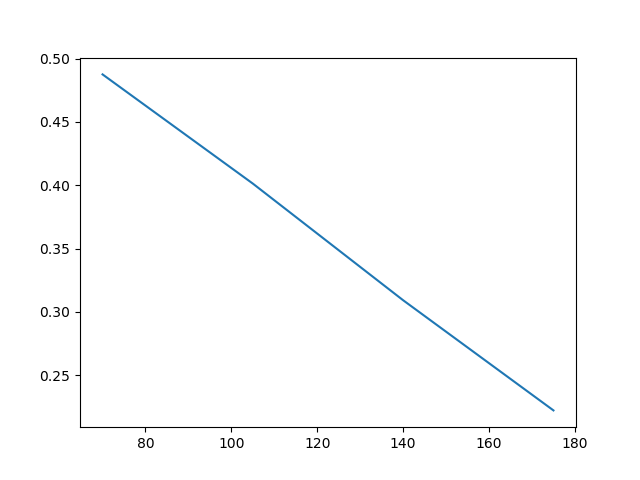

In [104]:
plt.figure()
plt.plot(xgood, ygood)

In [105]:
a1, a0 = np.polyfit(xgood, ygood, 1)

<IPython.core.display.Javascript object>


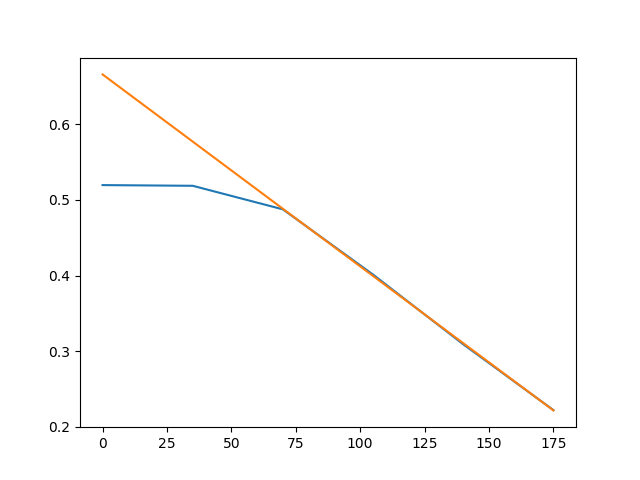

In [106]:
plt.figure()
plt.plot(x,y)
plt.plot(E0s, a0+a1*E0s)

In [107]:
a0_a = a0; a1_a = a1
def fit_func_a(E): return a0_a + a1_a * E

In [108]:
E0s

array([   0.,   35.,   70.,  105.,  140.,  175.])

## b

<IPython.core.display.Javascript object>


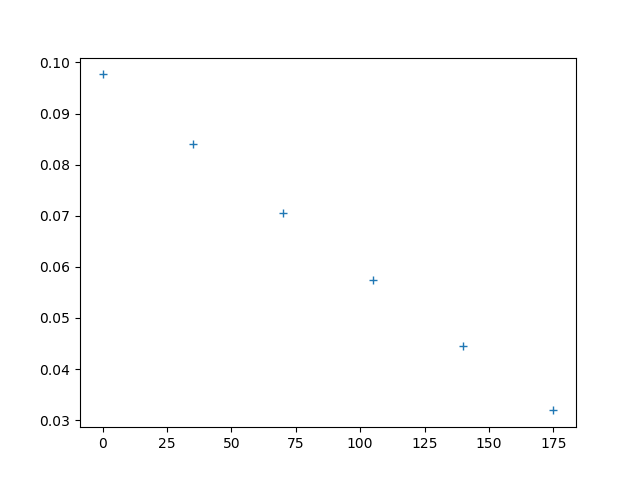

In [109]:
plt.figure()
x = E0s
y = np.array(get_p_list('b'))
plt.plot(x, y, '+')

In [110]:
a1, a0 = np.polyfit(x, y, 1)

<IPython.core.display.Javascript object>


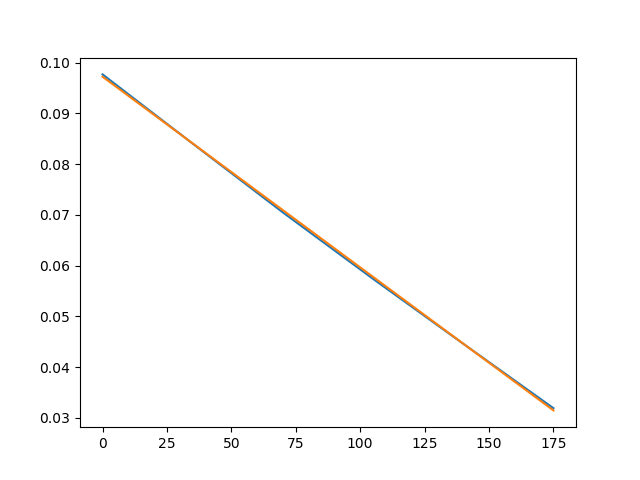

In [111]:
plt.figure()
plt.plot(x,y)
plt.plot(E0s, a0+a1*E0s)

In [112]:
a0_b = a0; a1_b = a1
def fit_func_b(E): return a0_b + a1_b * E

## t0
a and b are easy to fit. But t0 and sigma are harder to fit. We just do a simple interpolation

<IPython.core.display.Javascript object>


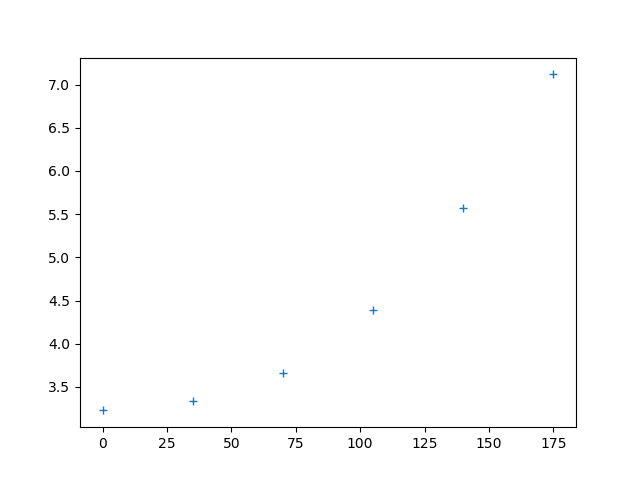

In [113]:
plt.figure()
plt.plot(E0s, get_p_list('t0'), '+')

There is only one outlier

In [114]:
mask = (E0s<250) + (E0s>260)

<IPython.core.display.Javascript object>


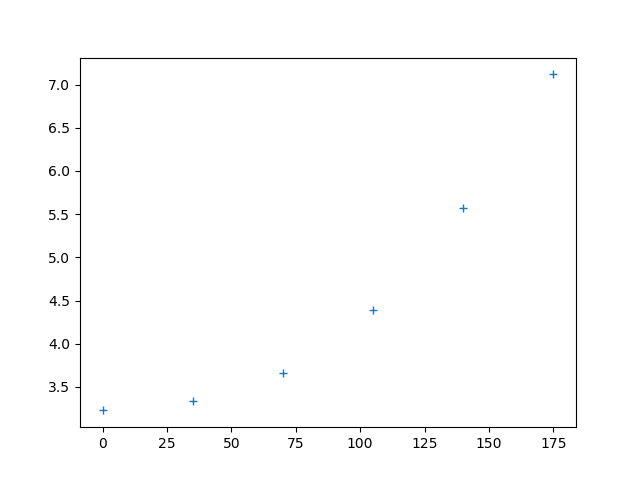

In [115]:
t0_x_good = E0s[mask]
# t0_y_good = np.array(get_p_list('t0'))[mask]
t0_y_good = np.array(get_p_list('t0'))
plt.figure()
plt.plot(t0_x_good, t0_y_good, '+')

We will use t0_x_good and t0_y_good for interpolation below

#### old code

<IPython.core.display.Javascript object>


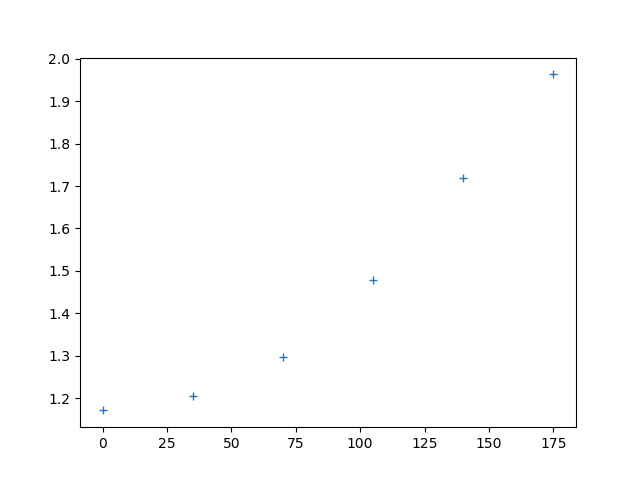

In [116]:
plt.figure()
plt.plot(E0s, np.log(get_p_list('t0')), '+')

In [117]:
import scipy.optimize as sopt

In [118]:
from numpy import inf

In [119]:
np.log(get_p_list('t0'))[np.log(get_p_list('t0'))==-np.inf]=0.0

In [120]:
np.log(get_p_list('t0'))[np.log(get_p_list('t0'))==-np.inf]

array([], dtype=float64)

In [121]:
np.isneginf(np.log(get_p_list('t0')))

array([False, False, False, False, False, False], dtype=bool)

In [122]:
np.isneginf(np.log(get_p_list('t0')))

array([False, False, False, False, False, False], dtype=bool)

In [123]:
np.log(get_p_list('t0'))[np.isneginf(np.log(get_p_list('t0')))]=0

In [124]:
x=np.log(get_p_list('t0'))

In [125]:
x[np.isneginf(x)]=0

In [126]:
print x

[ 1.17176699  1.20617189  1.29851727  1.47977262  1.71801017  1.96271238]


In [127]:
print (np.log(get_p_list('t0')))

[ 1.17176699  1.20617189  1.29851727  1.47977262  1.71801017  1.96271238]


In [128]:
def f_t0(E, a, bg): return a*E**2 + bg
(afit, bgfit), _ = sopt.curve_fit(f_t0, E0s, x)

<IPython.core.display.Javascript object>


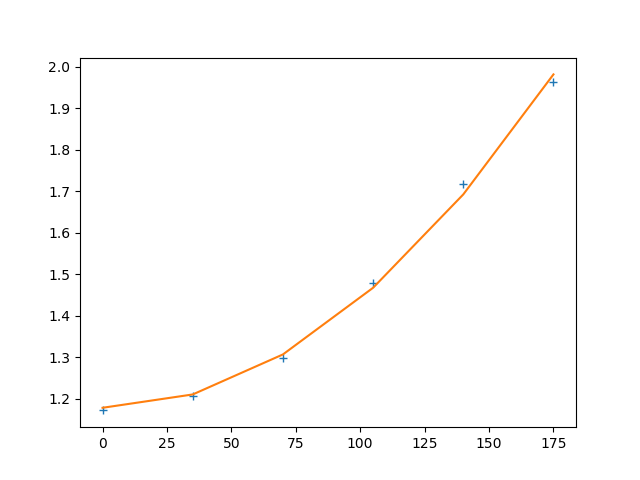

In [129]:
plt.figure()
plt.plot(E0s, x, '+')
plt.plot(E0s, bgfit + afit*E0s*E0s)

In [130]:
logy_t0 = x

In [131]:
mask1 = (E0s<150)
x1 = E0s[mask1]
logy1 = logy_t0[mask1]

In [132]:
(afit, bgfit), _ = sopt.curve_fit(f_t0, x1, logy1)

<IPython.core.display.Javascript object>


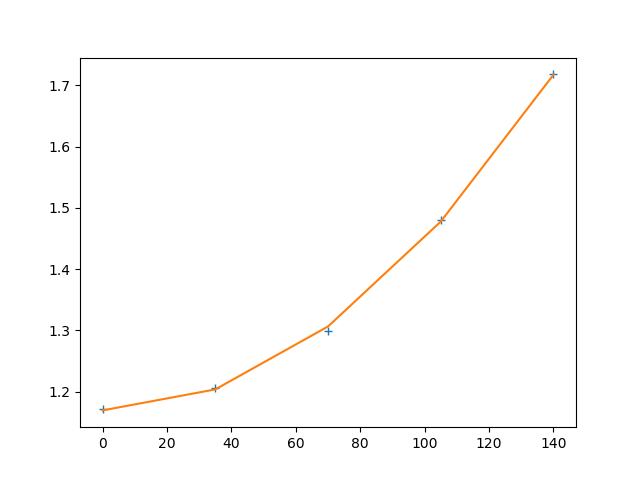

In [133]:
plt.figure()
plt.plot(x1, logy1, '+')
plt.plot(x1, f_t0(x1, afit, bgfit))

In [134]:
residual = logy1 - f_t0(x1, afit, bgfit)
stddev = np.std(residual)
np.abs(residual) > stddev * 2

array([False, False, False, False, False], dtype=bool)

<IPython.core.display.Javascript object>


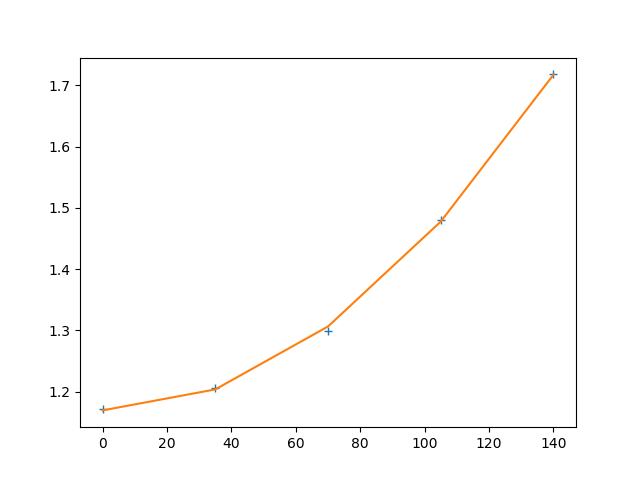

In [135]:
mask = np.abs(residual) < stddev * 2
x1m = x1[mask]
logy1m = logy1[mask]
(afit, bgfit), _ = sopt.curve_fit(f_t0, x1m, logy1m)

plt.figure()
plt.plot(x1, logy1, '+')
plt.plot(x1, f_t0(x1, afit, bgfit))

#### older code

In [136]:
afit_t0, bgfit_t0 = afit, bgfit
fit_func_t0 = lambda E: np.exp(f_t0(E, afit_t0, bgfit_t0))

<IPython.core.display.Javascript object>


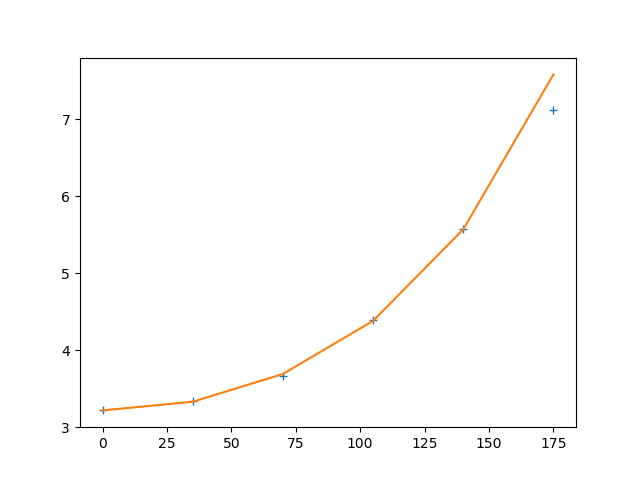

In [137]:
plt.figure()
plt.plot(E0s, get_p_list('t0'), '+')
plt.plot(E0s, fit_func_t0(E0s), '-')


## sigma

<IPython.core.display.Javascript object>


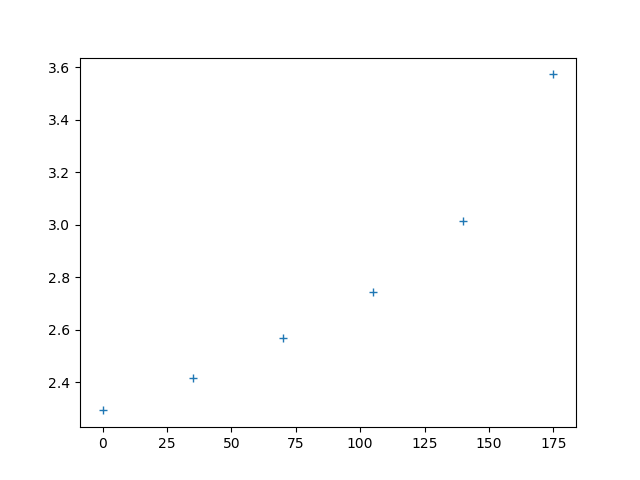

In [138]:
plt.figure()
plt.plot(E0s, get_p_list('sigma'), '+')

There is no really outliers. Will use the whole curve

In [139]:
sigma_x = E0s
sigma_y = np.array(get_p_list('sigma'))

#### old code 
last point is not really that interesting, we can regard it as outlier

<IPython.core.display.Javascript object>


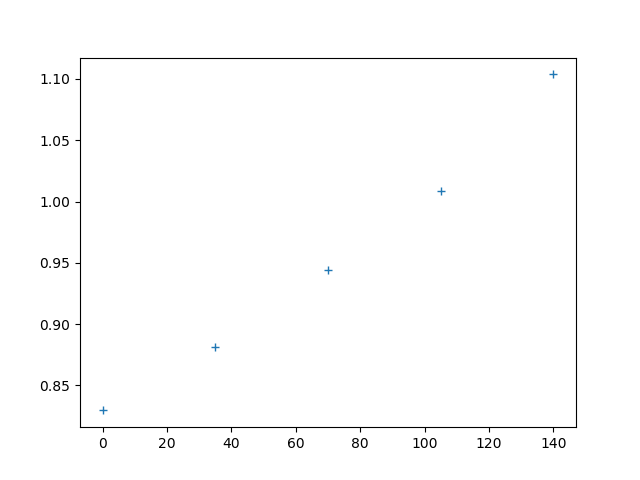

In [140]:
plt.figure()
plt.plot(E0s[:-1], np.log(get_p_list('sigma')[:-1]), '+')

In [141]:
import scipy.optimize as sopt

In [142]:
def f_sigma(E, a, bg): return a*E*E + bg
(afit, bgfit), _ = sopt.curve_fit(f_sigma, E0s[:-1], np.log(get_p_list('sigma')[:-1]))

<IPython.core.display.Javascript object>


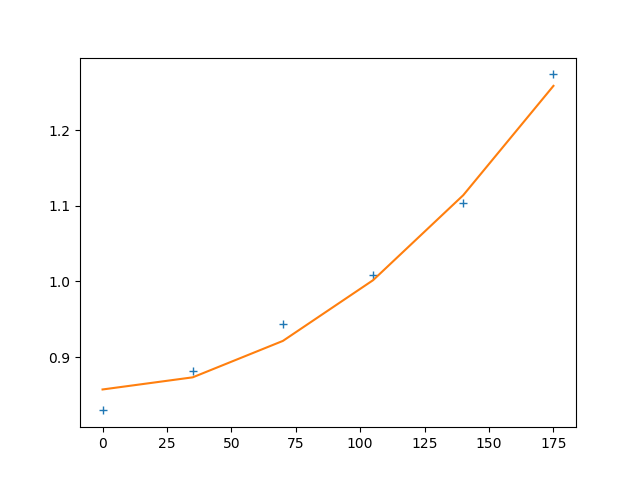

In [143]:
plt.figure()
plt.plot(E0s, np.log(get_p_list('sigma')), '+')
plt.plot(E0s, bgfit + afit*E0s*E0s)

In [144]:
afit_sigma, bgfit_sigma = afit, bgfit
fit_func_sigma = lambda E: np.exp(f_sigma(E, afit_sigma, bgfit_sigma))

# Test the interpolation / fitting

In [145]:
interped_funcs = dict(
    a = fit_func_a,
    # a = lambda E: np.interp(E, x_a, y_a),
    b = fit_func_b,
    # b = lambda E: np.interp(E, E0s, get_p_list('b')),
    # t0 = fit_func_t0,
    t0 = lambda E: np.interp(E, t0_x_good, t0_y_good),
    # sigma = fit_func_sigma,
    sigma = lambda E: np.interp(E, sigma_x, sigma_y),
    R = lambda E: 0*E+ 0.3, 
)

<IPython.core.display.Javascript object>


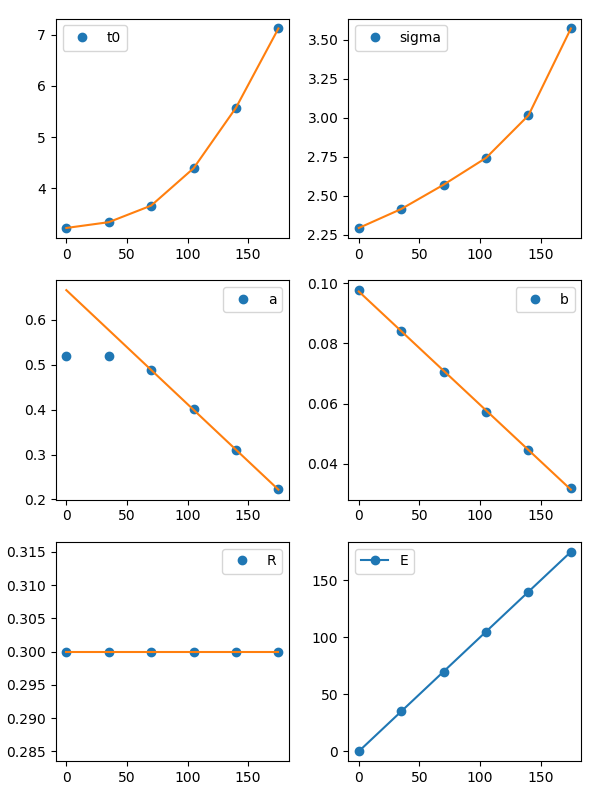

In [146]:
variables = 't0 sigma a b R'.split()
plt.figure(figsize=(6,8))

for i,v in enumerate(variables):
    plt.subplot(3, 2, i+1)
    x, y = E0s, get_p_list(v)
    plt.plot(x, y, 'o', label=v)
    # print v; break
    y2 = interped_funcs[v](x)
    plt.plot(x, y2)
    plt.legend()
    continue

plt.subplot(3, 2, 6)
plt.plot(E0s, E0s, '-o', label='E')
plt.legend()

plt.tight_layout()
plt.show()

Compare to sim data

<IPython.core.display.Javascript object>


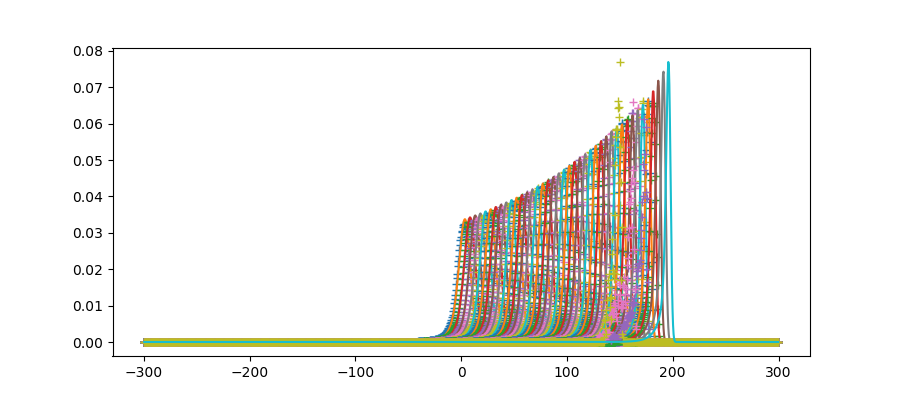

In [147]:
plt.figure(figsize=(9, 4))
for E0 in np.arange(0., 200., 5.):
    x,y0,y0err = getData(E0)
    params = dict()
    for name in interped_funcs.keys():
        value = interped_funcs[name](E0)
        params[name] = value
    y = icg.resolution(x, Ei=300., E0=E0, geom=geom, **params)
    y/=y.sum()
    # plt.errorbar(x, y0, y0err)
    plt.plot(x,y0, '+')
    plt.plot(x, y)
plt.show()

Try some Energy transfer values that were not simulated by mcvine

<IPython.core.display.Javascript object>


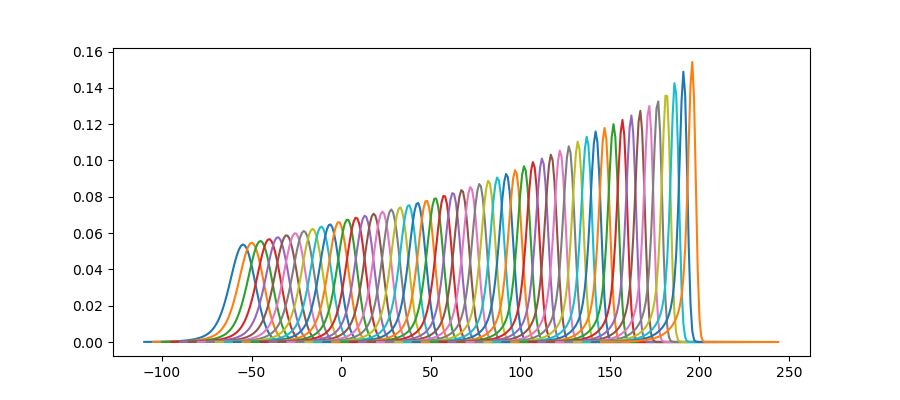

In [148]:
plt.figure(figsize=(9, 4))
for E0 in np.arange(-60., 200., 5.):
    params = dict()
    for name in interped_funcs.keys():
        value = interped_funcs[name](E0)
        params[name] = value
    x = np.arange(E0-50, E0+50, 1.)
    y = icg.resolution(x, Ei=300., E0=E0, geom=geom, **params)
    y/=y.sum()
    # plt.errorbar(x, y0, y0err)
    plt.plot(x, y)
plt.show()

It is not very good after 250meV

# Save parameters

In [149]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [150]:
%%writetemplate res_params_interped_funcs_C4H212S_FullCircle.py
import numpy as np
def linear(a0, a1):
    return lambda E: a0 + a1*E

a0_a = {a0_a}
a1_a = {a1_a}
a0_b = {a0_b}
a1_b = {a1_b}
from numpy import array
t0_x_good = {t0_x_good!r}
t0_y_good = {t0_y_good!r}
sigma_x = {sigma_x!r}
sigma_y = {sigma_y!r}

interped_funcs = dict(
    a = linear(a0_a, a1_a),
    b = linear(a0_b, a1_b),
    t0 = lambda E: np.interp(E, t0_x_good, t0_y_good),
    sigma = lambda E: np.interp(E, sigma_x, sigma_y),
    R = lambda E: 0*E+ 0.3, 
)

In [151]:
cat res_params_interped_funcs_C4H212S_FullCircle.py

import numpy as np
def linear(a0, a1):
    return lambda E: a0 + a1*E

a0_a = 0.66577580948
a1_a = -0.00253637992051
a0_b = 0.0972049230487
a1_b = -0.000375642688259
from numpy import array
t0_x_good = array([   0.,   35.,   70.,  105.,  140.,  175.])
t0_y_good = array([ 3.22769089,  3.34067168,  3.66386011,  4.39194693,  5.57342725,
        7.1186093 ])
sigma_x = array([   0.,   35.,   70.,  105.,  140.,  175.])
sigma_y = array([ 2.29254441,  2.41423228,  2.57039056,  2.74249276,  3.01542057,
        3.57316276])

interped_funcs = dict(
    a = linear(a0_a, a1_a),
    b = linear(a0_b, a1_b),
    t0 = lambda E: np.interp(E, t0_x_good, t0_y_good),
    sigma = lambda E: np.interp(E, sigma_x, sigma_y),
    R = lambda E: 0*E+ 0.3, 
)

# Old code

In [152]:
def fit_parabolic(x, y):
    a = np.polyfit(x, y, 2)
    y2 = np.dot(a, [x**2, x, 0*x+1])
    return a, y2
def parabolic(x, a):
    return a[0]*x*x + a[1]*x + a[2]

In [153]:
def make_parabolic_func(a):
    def _(x):
        return parabolic(x, a)
    return _
def make_exp_parabolic_func(a):
    def _(x):
        return np.exp(parabolic(x, a))
    return _

<IPython.core.display.Javascript object>


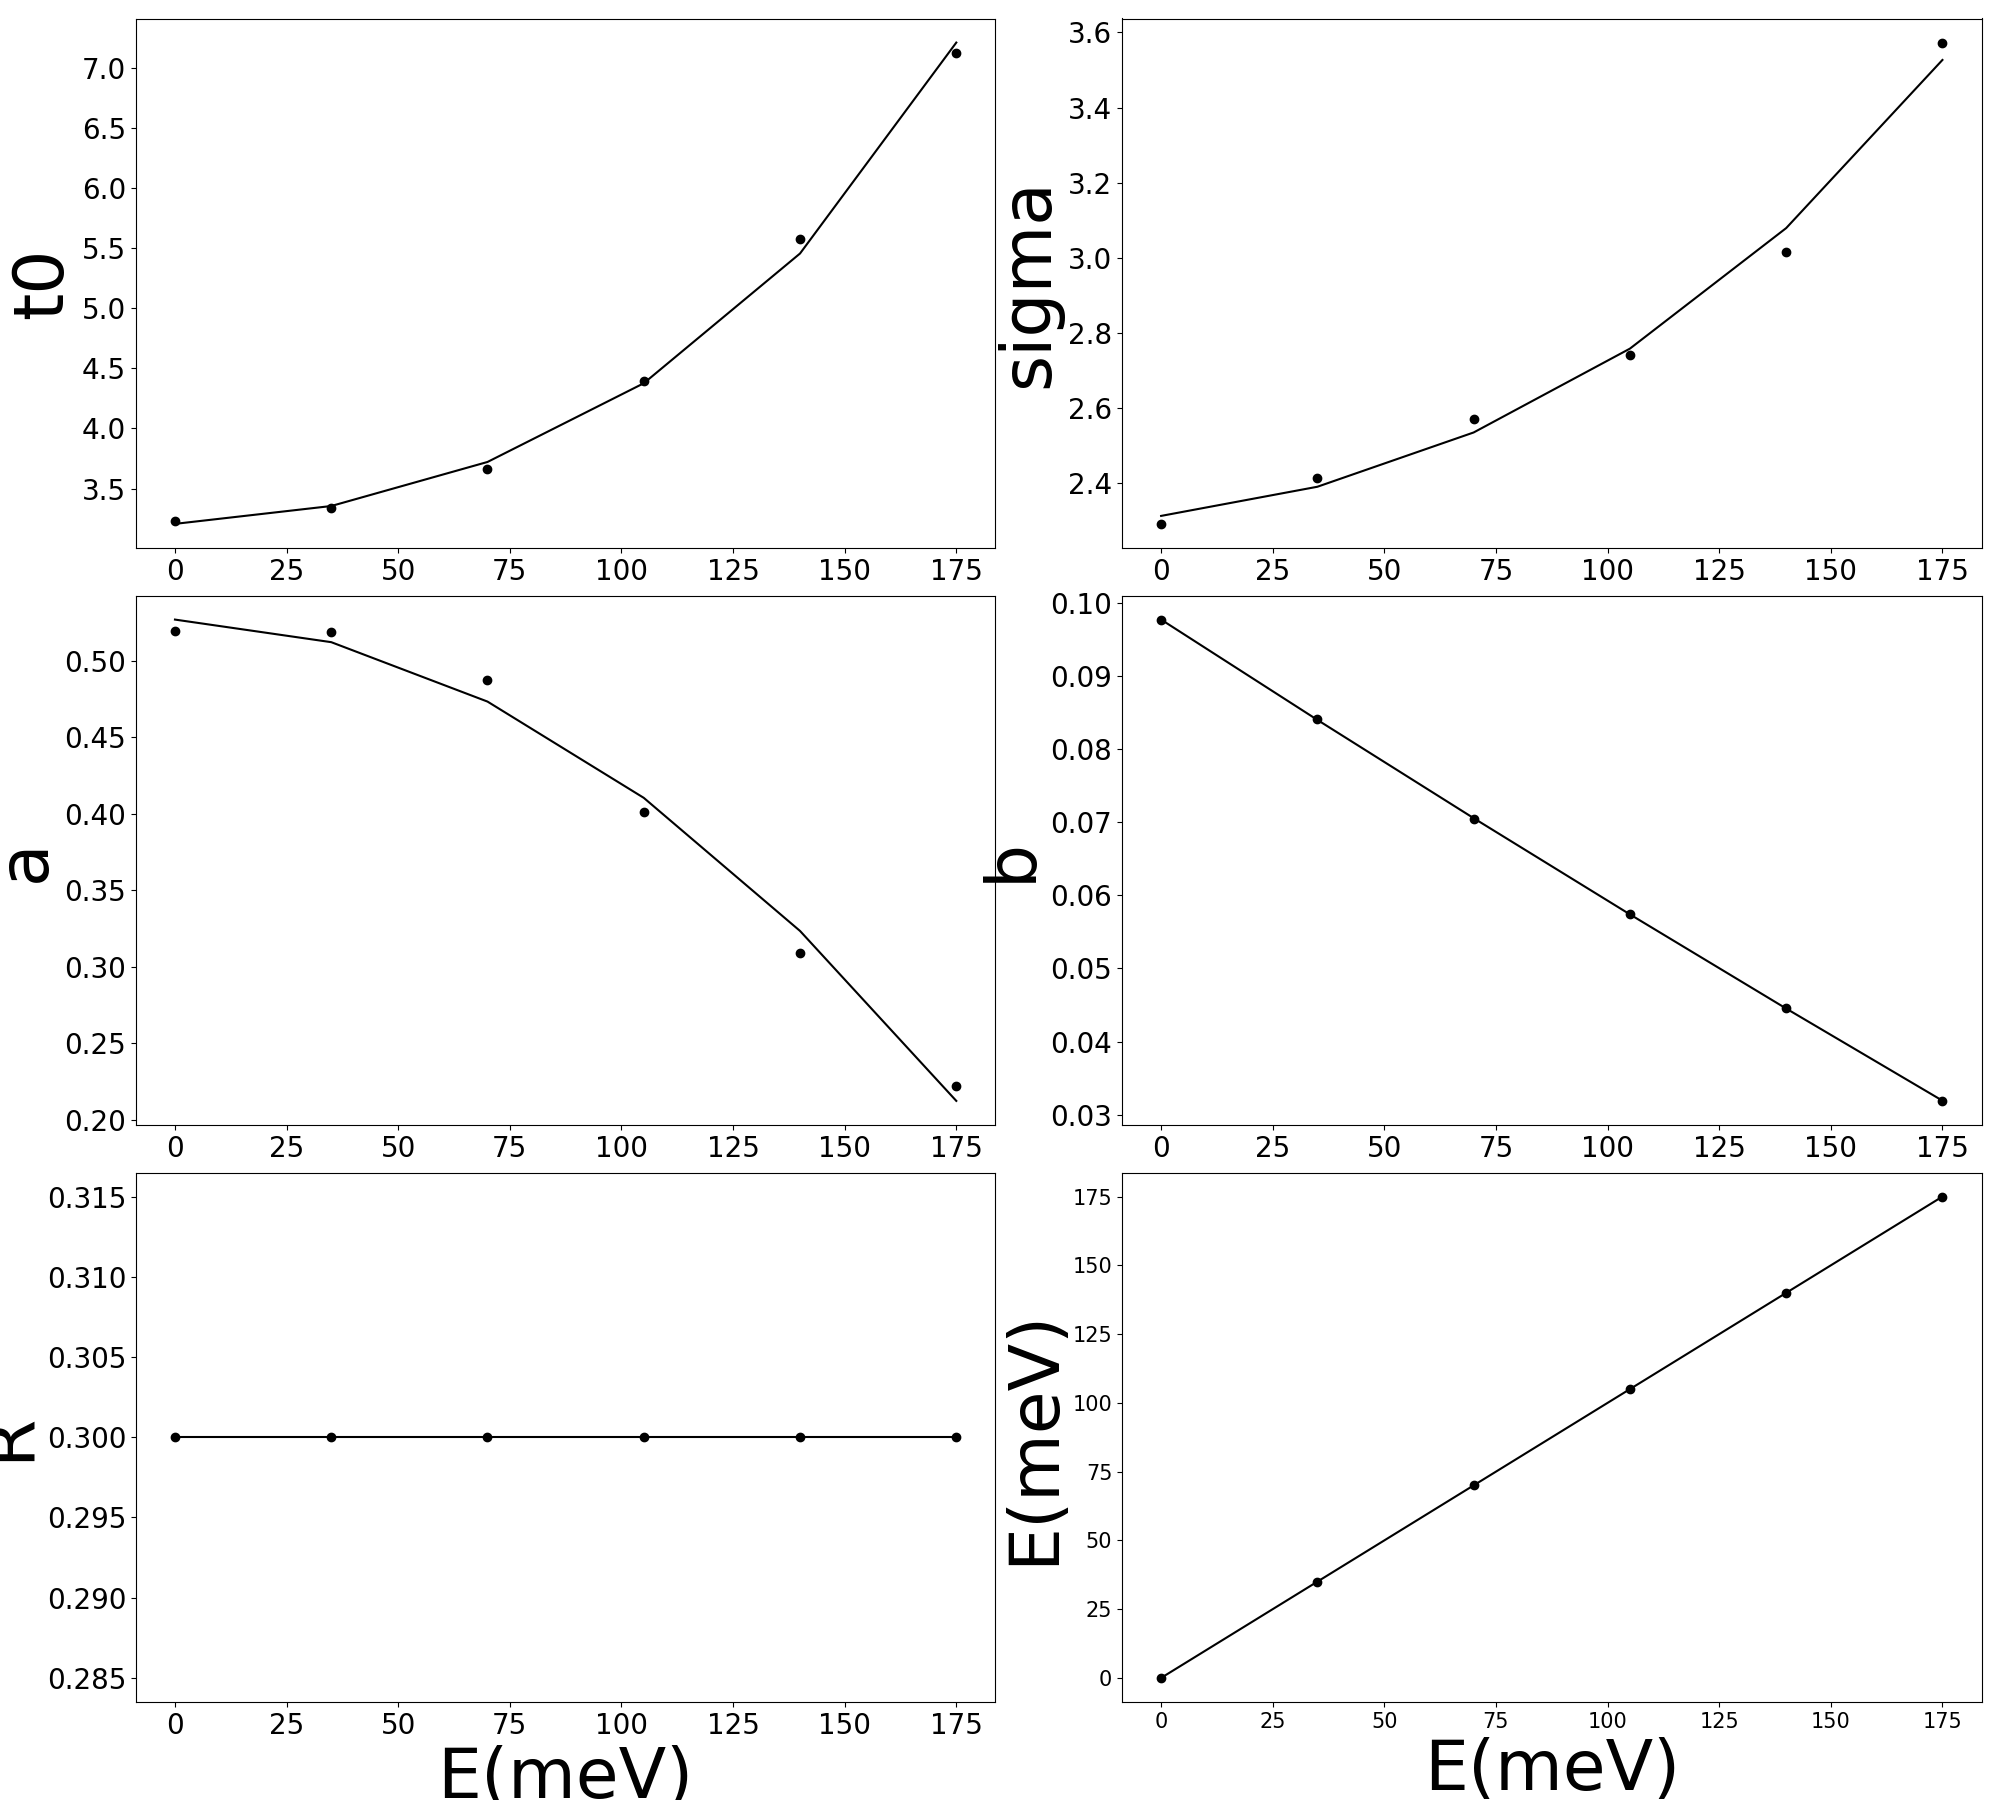

In [189]:
variables = 't0 sigma a b R'.split()
plt.figure(figsize=(20,18))
interped_funcs = dict()
for i,v in enumerate(variables):
    plt.subplot(3, 2, i+1)
    x, y = E0s, get_p_list(v)
#     plt.plot(x, y, '-o', label=v)
    plt.plot(x, y, 'o',color='black')
    plt.ylabel(v, fontsize=50)
    if v in ['t0', 'sigma']:
        a, y2 = fit_parabolic(x, np.log(y))
        plt.plot(x, np.exp(y2), color='black')
        interped_funcs[v] = make_exp_parabolic_func(a)
    else:
        a, y2 = fit_parabolic(x, y)
        plt.plot(x, y2,color='black')
        interped_funcs[v] = make_parabolic_func(a)
    plt.legend(prop={"family":"Times New Roman"})
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    continue
plt.xlabel('E(meV)', fontsize=50)
plt.tight_layout()
plt.subplot(3, 2, 6)
# plt.plot(E0s, E0s, '-o', label='E')
plt.plot(E0s, E0s, '-o', color='black')
plt.ylabel('E(meV)', fontsize=50)
plt.xlabel('E(meV)', fontsize=50)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(prop={"family":"Times New Roman"})
plt.savefig('fitted_parameters.eps',  dpi=1000)
plt.tight_layout()
plt.show()

# Create resolution matrix

In [73]:
Es = np.arange(0,295, 0.1)

<IPython.core.display.Javascript object>


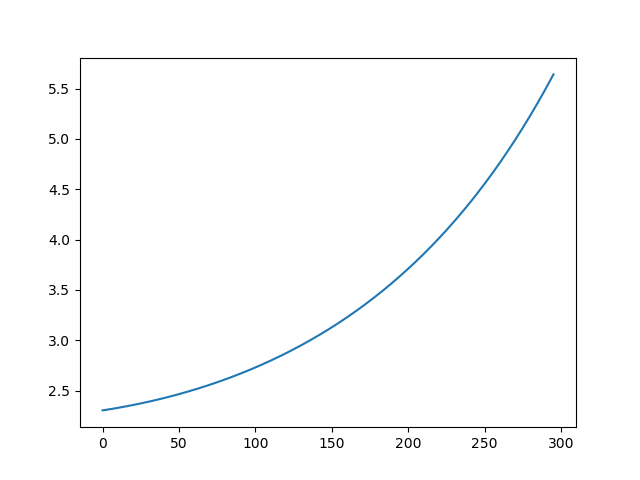

In [74]:
plt.figure()
plt.plot(Es, interped_funcs['sigma'](Es))

<IPython.core.display.Javascript object>


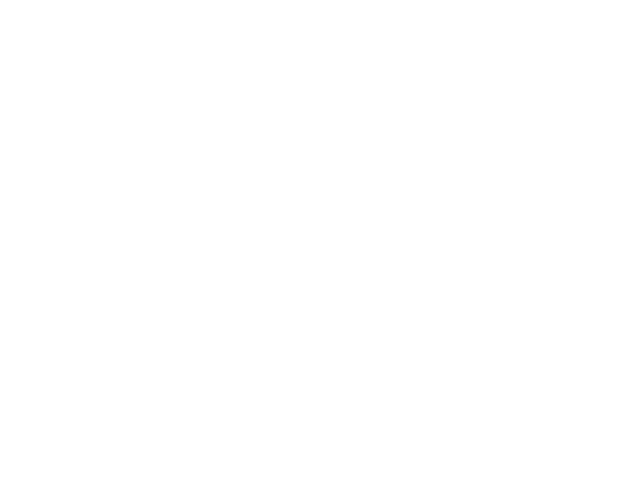

/home/fi0/anaconda2/envs/mcvine/lib/python2.7/site-packages/histogram/hdf/__init__.py:55: UserWarning: filename as url is deprecated
  warnings.warn("filename as url is deprecated")


IOError: unable to load histogram. filename=/home/fi0/dev/sandbox/SR-INS/srins/Jiao_Res/graphite-DOS/Ei_300_Q_4.47/resolutionFullCircle/ie, pathinfile=ie-E_210.0.h5, kwds={}

In [75]:
plt.figure()
for E0 in np.arange(0., 280., 30.):
    x,y0,y0err = getData(E0)
    params = dict()
    for name in interped_funcs.keys():
        value = interped_funcs[name](E0)
        params[name] = value
    y = icg.resolution(x, Ei=300., E0=E0, geom=geom, **params)
    y/=y.sum()
    # plt.errorbar(x, y0, y0err)
    plt.plot(x,y0, '+')
    plt.plot(x, y)
plt.show()